In [2]:
import torch
import mne
import pickle
import numpy as np

In [9]:
# Load the MNE object from the .pkl file
def load_data(file_path='data/resampled_epochs_subj_0.pkl'):
    with open(file_path, 'rb') as f:
        epochs = pickle.load(f)

    return epochs
#load_data()

# Data Processing
## MNE objects
done : 
* Keep only until 0.75 seconds 
* Go to Pytorch 
* Find good resources 
* Get train and test set

to do :
* Fourrier transform for optionnal undersampling 
* Check :     # Normalize data using mne library
    info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg') 


In [3]:
torch.cuda.is_available()

False

### Cut the data



In [4]:
from torch.utils.data import Dataset
from torchvision import transforms

from mne.decoding import Scaler
from mne import create_info

# Code from https://github.com/mne-tools/mne-torch.git

def get_data(file_path='data/resampled_epochs_subj_0.pkl'):
    # Load data
    epochs = load_data(file_path)
    # Crop the data to keep it only when the visual stimulus was on
    tmin = 0
    tmax = 0.746875
    epochs.crop(tmin=tmin, tmax=tmax)
    labels = epochs.events[:, 2] 
    # Normalize data using mne library
    info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg') 
    scaler = Scaler(info=info, scalings=None, with_mean=True, with_std=True)
    scaler.fit(epochs.get_data())
    epochs = scaler.transform(epochs.get_data())
    
    return epochs, labels

class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset

    Parameters
    ----------
    epochs_data : 3d array, shape (n_epochs, n_channels, n_times)
        The epochs data.
    epochs_labels : array of int, shape (n_epochs,)
        The epochs labels.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X)
        return X, y
from sklearn.model_selection import train_test_split    
def get_dataloaders(
    epochs,
    labels,
    batch_size):
    dataset_cls = EpochsDataset

    transform = transforms.Compose(
        [transforms.ToTensor() ]
    )

    epochs_train, epochs_test, labels_train, labels_test = train_test_split(epochs, labels, test_size=0.3, random_state=42)
    print(f'Dataset is split')
    train_set = dataset_cls(
        epochs_data = epochs_train,
        epochs_labels = labels_train,
        transform=transform,
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the iteration order over the dataset
        pin_memory=torch.cuda.is_available(),
        #drop_last=False,
        #num_workers=2,
    )

    val_set = dataset_cls(
        epochs_data = epochs_test,
        epochs_labels = labels_test,
        transform=transform,
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


In [5]:
#Make a vlidation set
from torch.utils.data import Dataset
from torchvision import transforms

from mne.decoding import Scaler
from mne import create_info

from sklearn.model_selection import train_test_split

# Code from https://github.com/mne-tools/mne-torch.git

def get_data(file_path='data/resampled_epochs_subj_0.pkl'):
    # Load data
    epochs = load_data(file_path)
    # Crop the data to keep it only when the visual stimulus was on
    tmin = 0
    tmax = 0.746875
    epochs.crop(tmin=tmin, tmax=tmax)
    labels = epochs.events[:, 2] 
    # Normalize data using mne library
    info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg') 
    scaler = Scaler(info=info, scalings=None, with_mean=True, with_std=True)
    scaler.fit(epochs.get_data())
    epochs = scaler.transform(epochs.get_data())
    
    return epochs, labels

class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset

    Parameters
    ----------
    epochs_data : 3d array, shape (n_epochs, n_channels, n_times)
        The epochs data.
    epochs_labels : array of int, shape (n_epochs,)
        The epochs labels.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X)
        return X, y
    
def get_dataloaders(
    epochs,
    labels,
    batch_size):
    dataset_cls = EpochsDataset

    transform = transforms.Compose(
        [transforms.ToTensor() ]
    )

    # Assuming 'X' is your feature set and 'y' is your target variable
    X_temp, epochs_test, y_temp, labels_test = train_test_split(epochs, labels, test_size=0.3, random_state=42)
    epochs_train, epochs_val, labels_train, labels_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
    print(f'Dataset is split')

    train_set = dataset_cls(
        epochs_data = epochs_train,
        epochs_labels = labels_train,
        transform=transform,
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the iteration order over the dataset
        pin_memory=torch.cuda.is_available(),
        #drop_last=False,
        #num_workers=2,
    )


    val_set = dataset_cls(
        epochs_data = epochs_val,
        epochs_labels = labels_val,
        transform=transform,
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=torch.cuda.is_available(),
    )


    test_set = dataset_cls(
        epochs_data = epochs_test,
        epochs_labels = labels_test,
        transform=transform,
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=torch.cuda.is_available(),
    )

    return train_loader, val_loader, test_loader


In [12]:
epochs, labels = get_data()
train_loader, val_loader, test_loader = get_dataloaders(epochs, labels, batch_size=1)
print(f'loaders are loaded')
list_test = []

for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 0:
        print(data.shape)
    list_test.append(1)
    print(data.shape)

print(len(list_test))

Dataset is split
loaders are loaded
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.S

In [13]:
inputs_train, targets_train = next(iter(train_loader))

In [14]:
print(inputs_train.shape)
print(targets_train.shape)

torch.Size([1, 1, 128, 192])
torch.Size([1])


# Observe the freqency domain

In [14]:
epochs = load_data('data/resampled_epochs_subj_0.pkl')
# Crop the data to keep it only when the visual stimulus was on
tmin = 0
tmax = 0.746875
epochs.crop(tmin=tmin, tmax=tmax)
labels = epochs.events[:, 2] 

In [15]:
import matplotlib.pyplot as plt
import mne
import numpy as np

# Assuming 'epochs' is your mne.Epochs object
psds, freqs = mne.time_frequency.psd_multitaper(epochs, fmin=1., fmax=70., bandwidth=1.)

# Convert power to dB scale
psds_db = 10 * np.log10(psds)

# Average across epochs
psds_db_mean = psds_db.mean(0)

# Plot the result
plt.figure(figsize=(8, 4))
plt.plot(freqs, psds_db_mean.T)
plt.title('PSD (dB) of EEG data (averaged across epochs)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.show()


AttributeError: module 'mne.time_frequency' has no attribute 'psd_multitaper'

    Using multitaper spectrum estimation with 7 DPSS windows
psds shape: (2989, 128, 96), freqs shape: (96,)


C:\Users\maudd\AppData\Local\Temp\ipykernel_4744\152861099.py:11: RuntimeWarning: divide by zero encountered in log10
  psds_db = 10 * np.log10(psds)


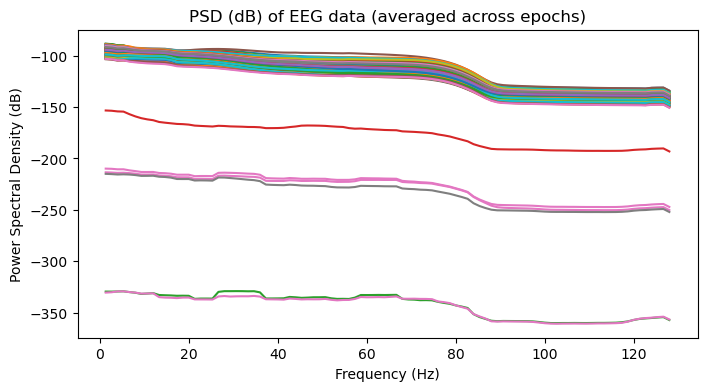

In [21]:


# Assuming 'epochs' is your mne.Epochs object
# Get the data and sampling frequency from the epochs
data = epochs.get_data()
sfreq = epochs.info['sfreq']

# Compute the PSD
psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq, fmin=1., fmax=200)
print(f'psds shape: {psds.shape}, freqs shape: {freqs.shape}')

# Convert power to dB scale
psds_db = 10 * np.log10(psds)

# Average across epochs
psds_db_mean = psds_db.mean(0)

# Plot the result
plt.figure(figsize=(8, 4))
plt.plot(freqs, psds_db_mean.T)
plt.title('PSD (dB) of EEG data (averaged across epochs)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.show()
